#### This note book is for interpretation of the trained model: cross-attention (peptide-MHCseq), in silico mutation, integrated grading, etc...

In [1]:
import os
os.environ["CUDa_VISIBLE-DEVICES"] = "1"

In [2]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight, resample, shuffle

2026-02-04 10:43:29.391993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-04 10:43:29.450486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-04 10:43:30.781566: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
df = pd.read_csv("Training_MHCII.csv") ## Main data file

In [4]:
df.columns

Index(['MHC_allele', 'Peptide', 'Immunogenicity', 'Sequence'], dtype='object')

In [11]:
RANDOM_SEED = 42
N_FOLDS = 5
EPOCHS = 60
BATCH_SIZE = 64
PEP_LEN = 15                      # peptides length (class I)
MHC_MAX_LEN = 269                # truncate/pad MHC sequences to this length
BALANCE_TRAIN = False            # If True, downsample majority class in each training fold
USE_CLASS_WEIGHT = True          # If True, compute class weights and pass to model.fit
#OUTPUT_DIR = "cct_cv_results"
#os.makedirs(OUTPUT_DIR, exist_ok=True)
# Reproducibility seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [12]:
a_vocab = list("ACDEFGHIKLMNPQRSTVWYX")  # canonical 20 AAs# Utilities: AA tokenizer / cleaning
aa2idx = {aa: i+1 for i, aa in enumerate(a_vocab)}  # 1..20
aa2idx["X"] = len(a_vocab) + 1  # unknown
PAD_IDX = 0
VOCAB_SIZE = len(a_vocab) + 2  # pad + 20 + unknown

In [13]:
def clean_seq(s):
    if pd.isna(s):
        return ""
    s = str(s).strip()
    s = "".join([c for c in s if "A" <= c <= "Z"])
    return s

In [14]:
def seq_to_int_array(seq, max_len):
    seq = clean_seq(seq)
    arr = np.zeros(max_len, dtype=np.int32)
    for i, ch in enumerate(seq[:max_len]):
        arr[i] = aa2idx.get(ch, aa2idx["X"])
    return arr

In [15]:
print("Encoding sequences to integer arrays...")
Xp_all = np.stack([seq_to_int_array(s, PEP_LEN) for s in df["Peptide"].values]) # peptide
Xm_all = np.stack([seq_to_int_array(s, MHC_MAX_LEN) for s in df["Sequence"].values])# mhc seq
y_all = df["Immunogenicity"].values.astype(np.int32)
print("Shapes: Xp_all, Xm_all, y_all =", Xp_all.shape, Xm_all.shape, y_all.shape)

Encoding sequences to integer arrays...
Shapes: Xp_all, Xm_all, y_all = (7887, 15) (7887, 269) (7887,)


In [18]:
def deepHimmune (vocab_size=len(a_vocab)+1,
                            pep_len=PEP_LEN,
                            mhc_len=MHC_MAX_LEN,
                            #esm_dim=Esm_peptide.shape[1],
                            embed_dim=16,
                            conv_filters=32,
                            esm_bottleneck=128,
                            num_heads=1,
                            attn_key_dim=32,
                            dropout_rate=0.5,
                            l2_reg=1e-4):
    # Inputs
    pep_input = Input(shape=(pep_len,), dtype=tf.int32, name="pep_input")
    mhc_input = Input(shape=(mhc_len,), dtype=tf.int32, name="mhc_input")
    esm_pep_input = Input(shape=(esm_dim,), dtype=tf.float32, name="esm_pep_input")
    esm_mhc_input = Input(shape=(esm_dim,), dtype=tf.float32, name="esm_mhc_input")
    
    # CCT-like small branch function
    def small_cct_branch(seq_input, seq_len, name):
        # token embedding + spatial dropout
        x = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_len,
                      embeddings_regularizer=l2(l2_reg))(seq_input)
        x = SpatialDropout1D(rate=0.2)(x)
        # lightweight conv
        x = Conv1D(conv_filters, kernel_size=3, padding="same", activation="relu",
                   kernel_regularizer=l2(l2_reg))(x)
        # pre-LN + small self-attention
        norm = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=attn_key_dim)(norm, norm)
        attn = Dropout(dropout_rate)(attn)
        out = Add()([x, attn])
        out = LayerNormalization()(out)
        return out
    
    pep_cct = small_cct_branch(pep_input, pep_len, "pep_cct")
    mhc_cct = small_cct_branch(mhc_input, mhc_len, "mhc_cct")
    
    # Cross-attention: peptide queries -> mhc keys/values (light)
    pep_norm = LayerNormalization()(pep_cct)
    mhc_norm = LayerNormalization()(mhc_cct)
    cross = MultiHeadAttention(num_heads=2, key_dim=attn_key_dim)(pep_norm, mhc_norm)
    cross = Dropout(dropout_rate)(cross)
    cross = Add()([pep_cct, cross])
    cross = LayerNormalization()(cross)
    cross = Dropout(dropout_rate)(cross)
    cross_pool = GlobalAveragePooling1D()(cross)  # shape (batch, conv_filters)
    
    # ESM bottleneck (compress frozen precomputed embeddings)
    esm_concat = Concatenate()([esm_pep_input, esm_mhc_input])  # shape (batch, 2560)
    esm_b = Dense(esm_bottleneck, activation="relu", kernel_regularizer=l2(l2_reg))(esm_concat)
    esm_b = Dropout(dropout_rate)(esm_b)
    
    # Fusion
    fusion = Concatenate()([cross_pool, esm_b])  # small dims
    # small fusion attention
    fusion_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(fusion)
    fusion_norm = LayerNormalization()(fusion_exp)
    fusion_attn = MultiHeadAttention(num_heads=2, key_dim=attn_key_dim)(fusion_norm, fusion_norm)
    fusion_attn = Dropout(dropout_rate)(fusion_attn)
    fusion_attn = Add()([fusion_exp, fusion_attn])
    fusion_attn = Lambda(lambda x: tf.squeeze(x, axis=1))(fusion_attn)
    fusion_attn = LayerNormalization()(fusion_attn)
    fusion_attn = Dropout(dropout_rate)(fusion_attn)
    
    # Final small classifier (single bottleneck)
    x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(fusion_attn)
    x = Dropout(0.5)(x)
    out = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[pep_input, mhc_input, esm_pep_input, esm_mhc_input], outputs=out)
    # compile with gradient clipping
    opt = Adam(learning_rate=5e-4, clipnorm=1.0)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model
## original model

In [3]:
# downstream tasks,fine tunning

In [19]:
model = build_cct_dual_input_with_attn(
    peptide_len=PEP_LEN,
    mhc_len=269,
    vocab_size=VOCAB_SIZE,
    embed_dim=16,
    conv_filters=32,
    tokenizer_filters=128,
    trans_layers=2,
    num_heads=1,
    ff_dim=128,
    dropout=0.4,
    cls_dropout=0.4
)   # re_create the model for dowmstream analysis

def build_cct_dual_input_with_attn(
    peptide_len=PEP_LEN,
    mhc_len=269,
    vocab_size=VOCAB_SIZE,
    embed_dim=64,
    tokenizer_filters=128,
    trans_layers=2,
    head_size=32,
    num_heads=4,
    ff_dim=128,
    dropout=0.4,
    cls_dropout=0.4
):
    # =========================
    # Inputs
    # =========================
    p_in = Input(shape=(peptide_len,), dtype="int32", name="peptide_input")
    m_in = Input(shape=(mhc_len,), dtype="int32", name="mhc_input")

    # =========================
    # Shared embedding
    # =========================
    embed = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True,
        name="aa_embedding"
    )
    p_emb = embed(p_in)  # (B, 15, D)
    m_emb = embed(m_in)  # (B, 269, D)

    # =========================
    # Positional embeddings
    # =========================
    pos_p = layers.Embedding(peptide_len, embed_dim, name="pos_pep")
    pos_m = layers.Embedding(mhc_len, embed_dim, name="pos_mhc")

    p_emb = p_emb + pos_p(tf.range(peptide_len))
    m_emb = m_emb + pos_m(tf.range(mhc_len))

    # =========================
    # Conv tokenizers
    # =========================
    p_tok = conv_tokenizer(
        p_emb, filters=tokenizer_filters,
        kernel_size=3, dropout=dropout, name="pep_tok"
    )
    m_tok = conv_tokenizer(
        m_emb, filters=tokenizer_filters,
        kernel_size=5, dropout=dropout, name="mhc_tok"
    )

    # =========================
    # Projection
    # =========================
    proj = layers.Dense(tokenizer_filters, name="proj_dense")
    p_tok = proj(p_tok)
    m_tok = proj(m_tok)

    # =========================
    # Independent transformers
    # =========================
    for i in range(trans_layers):
        p_tok = transformer_encoder(
            p_tok, head_size, num_heads,
            ff_dim, dropout, name=f"pep_enc_{i}"
        )
        m_tok = transformer_encoder(
            m_tok, head_size, num_heads,
            ff_dim, dropout, name=f"mhc_enc_{i}"
        )

    # =========================
    # 🔥 Cross-attention (RESIDUE–RESIDUE)
    # =========================
    cross_layer = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=head_size,
        name="cross_attn"
    )

    cross_out, attn_scores = cross_layer(
        p_tok,
        m_tok,
        m_tok,
        return_attention_scores=True
    )
    # attn_scores: (B, heads, 15, 269)

    cross_out = layers.Dropout(dropout, name="cross_attn_drop")(cross_out)
    p_out = layers.Add(name="cross_add")([p_tok, cross_out])
    p_out = layers.LayerNormalization(name="cross_ln")(p_out)

    # =========================
    # Optional transformer after fusion
    # =========================
    p_out = transformer_encoder(
        p_out, head_size, num_heads,
        ff_dim, dropout, name="pep_after_cross"
    )

    # =========================
    # Pooling
    # =========================
    p_pool = AttentionPooling(name="pep_pool")(p_out)
    m_pool = AttentionPooling(name="mhc_pool")(m_tok)

    # =========================
    # Classification head
    # =========================
    x = layers.Concatenate(name="concat")([p_pool, m_pool])
    x = layers.Dense(128, activation="gelu", name="head_dense1")(x)
    x = layers.Dropout(cls_dropout, name="head_drop1")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    # =========================
    # Model outputs BOTH prediction and attention
    # =========================
    model = Model(
        inputs=[p_in, m_in],
        outputs=[out, attn_scores],
        name="CCT_dual_seq_with_attn"
    )

    return model


In [ ]:
from tensorflow.keras.models import load_model
from keras_self_attention import SeqSelfAttention

# 2. Load weights from the provided .keras file 
weights_path = "five_fold_model_12_16_Full_seq_MHCII_2.keras"   # model weight in fold 2

# Try to load weights
try:
    model.load_weights(weights_path)
    print("Weights loaded successfully into recreated model.")
except Exception as e:
    print("model.load_weights(...) failed with error:\n", e)
    print("Trying alternative: load the .keras archive with safe deserialization (last resort).")

In [20]:
y_pred, attn_scores = model.predict([Xp_all, Xm_all])

print(attn_scores.shape)


2026-01-20 13:32:49.303129: I external/local_xla/xla/service/service.cc:163] XLA service 0x7463ec01aa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-20 13:32:49.303169: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2026-01-20 13:32:49.303177: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2026-01-20 13:32:49.409542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-20 13:32:49.725254: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


 29/247 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

I0000 00:00:1768883572.158958 3650942 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/247 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step
(7887, 4, 15, 269)


In [21]:
attn_head_avg = attn_scores.mean(axis=1)
print(attn_head_avg.shape)


(7887, 15, 269)


In [22]:
print(len(df), attn_head_avg.shape[0])



7887 7887


In [30]:
TOP_K = 10000 ## top 10000 interactions of peptide to MHC, size ~~1.2GB
records = []
N = len(df)

for sample_idx in range(N):

    peptide_seq = df.loc[sample_idx, "Peptide"]
    mhc_seq     = df.loc[sample_idx, "Sequence"]
    mhc_allele  = df.loc[sample_idx, "MHC_allele"]

    # (15, 269) attention map for THIS sample
    attn_map = attn_head_avg[sample_idx]

    # Flatten + top-K
    flat_idx = np.argsort(attn_map.ravel())[::-1][:TOP_K]
    pep_pos, mhc_pos = np.unravel_index(flat_idx, attn_map.shape)

    records.append({
        "MHC allele Name": mhc_allele,
        "Peptide": peptide_seq,
        "Peptide AA": [peptide_seq[i] for i in pep_pos],
        "Peptide position": (pep_pos + 1).tolist(),
        "MHC AA": [mhc_seq[j] for j in mhc_pos],
        "MHC position": (mhc_pos + 1).tolist(),
        "Attention weight (based on MHC position)": attn_map[pep_pos, mhc_pos].tolist()
    })

# Create dataframe
attn_df = pd.DataFrame(records)



In [31]:
attn_df.columns

Index(['MHC allele Name', 'Peptide', 'Peptide AA', 'Peptide position',
       'MHC AA', 'MHC position', 'Attention weight (based on MHC position)'],
      dtype='object')

In [35]:
attn_df

,MHC allele Name,Peptide,Peptide AA,Peptide position,MHC AA,MHC position,Attention weight (based on MHC position)
0,HLA-DRB1-0101,YLMDKLNLTKSDVQL,"[D, N, K, L, M, D, S, T, L, Y, S, M, M, K, L, ...","[4, 7, 10, 6, 3, 12, 11, 9, 6, 1, 11, 3, 3, 10...","[C, C, C, C, C, C, C, C, Q, C, Q, T, Q, Q, C, ...","[44, 44, 44, 44, 44, 44, 44, 44, 225, 44, 225,...","[0.3208490312099457, 0.2397904098033905, 0.151..."
1,H2-IAb,SDFMSKVNGAVKRVA,"[V, V, A, M, V, M, V, M, A, A, M, V, S, V, V, ...","[7, 11, 15, 4, 11, 4, 11, 4, 15, 15, 4, 7, 1, ...","[V, V, V, V, S, P, S, S, S, S, S, P, V, R, S, ...","[14, 14, 14, 14, 210, 206, 225, 210, 225, 210,...","[0.07549066841602325, 0.07456649839878082, 0.0..."
2,H2-IAb,IIDWKGANPVTVINE,"[A, V, E, I, K, G, T, K, K, G, N, A, I, G, A, ...","[7, 10, 15, 13, 5, 6, 11, 5, 5, 6, 8, 7, 1, 6,...","[V, V, V, V, V, V, V, S, S, R, V, S, V, L, P, ...","[14, 14, 14, 14, 14, 14, 14, 210, 225, 256, 14...","[0.08121306449174881, 0.07023247331380844, 0.0..."
3,H2-IAb,MIALLILSLTCSXXX,"[X, X, X, C, X, X, X, L, X, X, S, X, T, X, L, ...","[14, 13, 15, 11, 14, 14, 15, 9, 15, 13, 12, 13...","[V, V, V, V, S, S, S, V, S, S, V, S, V, Q, V, ...","[14, 14, 14, 14, 225, 210, 225, 14, 210, 225, ...","[0.18706578016281128, 0.18163970112800598, 0.1..."
4,H2-IAb,GYESLDLCLEGVGIH,"[E, E, E, D, E, D, E, E, D, D, L, G, H, D, E, ...","[10, 3, 3, 6, 3, 6, 10, 10, 6, 6, 5, 11, 15, 6...","[V, V, S, S, S, V, S, S, S, P, V, P, V, C, P, ...","[14, 14, 225, 225, 210, 14, 225, 210, 210, 206...","[0.09888538718223572, 0.06391680240631104, 0.0..."
...,...,...,...,...,...,...,...
7882,H2-IAb,IADNNVRLVCTLLNA,"[D, L, A, R, T, C, D, D, N, V, R, A, I, R, A, ...","[3, 13, 15, 7, 11, 10, 3, 3, 4, 6, 7, 15, 1, 7...","[V, V, V, V, V, V, S, S, V, V, S, S, V, S, S, ...","[14, 14, 14, 14, 14, 14, 210, 225, 14, 14, 225...","[0.14133964478969574, 0.11848968267440796, 0.1..."
7883,H2-IAb,INQMVNTVLITVYEK,"[I, N, E, I, Q, M, V, E, E, T, Y, N, N, I, T, ...","[1, 6, 14, 10, 3, 4, 5, 14, 14, 11, 13, 6, 6, ...","[V, V, V, V, V, V, V, S, S, V, V, S, S, S, V, ...","[14, 14, 14, 14, 14, 14, 14, 210, 225, 14, 14,...","[0.15409895777702332, 0.13683347404003143, 0.1..."
7884,HLA-DQB1-0301,SGFVSLLAPGAKQNV,"[Q, A, Q, G, V, A, A, S, G, L, A, Q, V, S, L, ...","[13, 11, 13, 10, 15, 8, 11, 1, 10, 6, 8, 13, 4...","[Q, Q, S, Q, Q, Q, S, Q, S, Q, S, G, Q, S, Q, ...","[228, 228, 233, 228, 228, 228, 233, 228, 233, ...","[0.24604380130767822, 0.10408347100019455, 0.0..."
7885,H2-IAb,MKVVIVTSVASLLDX,"[X, D, D, T, M, D, A, M, X, X, D, M, L, A, A, ...","[15, 14, 14, 7, 1, 14, 10, 1, 15, 15, 14, 1, 1...","[V, V, S, V, V, S, V, S, S, S, C, S, V, S, S, ...","[14, 14, 225, 14, 14, 210, 14, 225, 210, 225, ...","[0.1439606100320816, 0.14216507971286774, 0.07..."


In [34]:
attn_df.to_csv(
    "raw_aminoacid_interaction_2025_01_20.csv",
    index=False
)


In [19]:
## delete duplicate positions if necessary

In [42]:
def deduplicate_sort_with_attention(positions, aas, weights, agg="max"):
    """
    positions: list[int]
    aas: list[str]
    weights: list[float]
    agg: 'max' or 'mean'
    """

    pos_dict = {}

    for p, a, w in zip(positions, aas, weights):
        if p not in pos_dict:
            pos_dict[p] = {"aa": a, "weights": [w]}
        else:
            pos_dict[p]["weights"].append(w)

    # aggregate attention
    records = []
    for p, v in pos_dict.items():
        if agg == "max":
            attn = max(v["weights"])
        elif agg == "mean":
            attn = float(np.mean(v["weights"]))
        else:
            raise ValueError("agg must be 'max' or 'mean'")

        records.append((p, v["aa"], attn))

    # sort by position
    records.sort(key=lambda x: x[0])

    positions_sorted = [r[0] for r in records]
    aas_sorted = [r[1] for r in records]
    attn_sorted = [r[2] for r in records]

    return positions_sorted, aas_sorted, attn_sorted


In [39]:
clean_records = []

for _, row in attn_df.iterrows():

    # ---- Peptide ----
    pep_pos, pep_aa, pep_attn = deduplicate_sort_with_attention(
        row["Peptide position"],
        row["Peptide AA"],
        row["Attention weight (based on MHC position)"],
        agg="max"
    )

    # ---- MHC ----
    mhc_pos, mhc_aa, mhc_attn = deduplicate_sort_with_attention(
        row["MHC position"],
        row["MHC AA"],
        row["Attention weight (based on MHC position)"],
        agg="max"
    )

    clean_records.append({
        "MHC allele Name": row["MHC allele Name"],
        "Peptide": row["Peptide"],

        # peptide
        "Peptide AA (unique)": pep_aa,
        "Peptide position (unique)": pep_pos,
        #"Peptide attention (agg)": pep_attn,

        # mhc
        "MHC AA (unique)": mhc_aa,
        "MHC position (unique)": mhc_pos,
        "MHC attention (agg)": mhc_attn
    })

clean_attn_df = pd.DataFrame(clean_records)


In [40]:
clean_attn_df

,MHC allele Name,Peptide,Peptide AA (unique),Peptide position (unique),MHC AA (unique),MHC position (unique),MHC attention (agg)
0,HLA-DRB1-0101,YLMDKLNLTKSDVQL,"[Y, L, M, D, L, N, L, T, K, S, D, Q, L]","[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15]","[V, P, P, L, C, E, E, P, S, R, E, V, P, Q, S, ...","[2, 7, 34, 40, 44, 65, 116, 126, 149, 162, 167...","[0.021051865071058273, 0.01582998037338257, 0...."
1,H2-IAb,SDFMSKVNGAVKRVA,"[S, D, F, M, S, K, V, N, G, A, V, K, A]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15]","[P, V, S, P, R, F, Q, M, C, V, L, E, Y, K, T, ...","[6, 14, 21, 23, 32, 34, 37, 39, 42, 71, 80, 86...","[0.013245122507214546, 0.07549067586660385, 0...."
2,H2-IAb,IIDWKGANPVTVINE,"[I, D, W, K, G, A, N, P, V, T, I, E]","[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15]","[V, S, F, Q, C, V, L, E, Y, K, P, S, W, S, S, ...","[14, 21, 34, 37, 42, 71, 80, 86, 151, 154, 206...","[0.0812130719423294, 0.018505143001675606, 0.0..."
3,H2-IAb,MIALLILSLTCSXXX,"[M, I, A, L, I, S, L, T, C, S, X, X, X]","[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15]","[V, S, R, F, Q, M, C, L, Y, K, P, S, W, S, L, ...","[14, 21, 32, 34, 37, 39, 42, 80, 151, 154, 206...","[0.1870657354593277, 0.027039943262934685, 0.0..."
4,H2-IAb,GYESLDLCLEGVGIH,"[G, Y, E, L, D, C, L, E, G, V, G, H]","[1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 15]","[P, V, F, Q, M, C, V, R, L, E, T, Y, K, P, S, ...","[6, 14, 34, 37, 39, 42, 71, 75, 80, 86, 117, 1...","[0.015609584748744965, 0.09888534992933273, 0...."
...,...,...,...,...,...,...,...
7882,H2-IAb,IADNNVRLVCTLLNA,"[I, D, N, N, V, R, V, C, T, L, N, A]","[1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15]","[V, S, R, F, Q, M, C, V, L, Y, K, P, S, W, S, ...","[14, 21, 32, 34, 37, 39, 42, 71, 80, 151, 154,...","[0.14133964478969574, 0.01471816748380661, 0.0..."
7883,H2-IAb,INQMVNTVLITVYEK,"[I, N, Q, M, V, N, T, V, L, I, T, Y, E]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14]","[V, S, R, F, Q, M, C, L, T, Y, K, P, S, S, L, ...","[14, 21, 32, 34, 37, 39, 42, 80, 117, 151, 154...","[0.1540989875793457, 0.01778692752122879, 0.01..."
7884,HLA-DQB1-0301,SGFVSLLAPGAKQNV,"[S, F, V, L, L, A, P, G, A, Q, N, V]","[1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15]","[S, G, E, V, Q, C, Y, E, P, Q, S, S, Q]","[2, 12, 37, 40, 42, 47, 69, 91, 210, 228, 229,...","[0.025777706876397133, 0.04888448491692543, 0...."
7885,H2-IAb,MKVVIVTSVASLLDX,"[M, K, I, V, T, V, A, L, D, X]","[1, 2, 5, 6, 7, 9, 10, 13, 14, 15]","[P, V, S, P, R, F, Q, M, C, D, V, L, E, T, Y, ...","[6, 14, 21, 23, 32, 34, 37, 39, 42, 70, 71, 80...","[0.014420383609831333, 0.1439605951309204, 0.0..."


In [49]:
clean_attn_df["MHC allele Name"].nunique()
clean_attn_df["MHC allele Name"].value_counts().head()

MHC allele Name
H2-IAb           3054
HLA-DQB1-0301     753
HLA-DRB1-0101     477
H2-IAd            362
HLA-DRB1-0401     320
Name: count, dtype: int64

In [45]:
clean_attn_df.to_csv(
    "aminoacid_interaction_top_interaction_CLEANED_2025_01_12.csv",
    index=False
)


#### Per allle importance map

In [50]:
# explode list columns
attn_long = attn_df.explode(
    ["Peptide AA", "Peptide position",
     "MHC AA", "MHC position",
     "Attention weight (based on MHC position)"]
).reset_index(drop=True)

attn_long.head()

,MHC allele Name,Peptide,Peptide AA,Peptide position,MHC AA,MHC position,Attention weight (based on MHC position)
0,HLA-DRB1-0101,YLMDKLNLTKSDVQL,D,4,C,44,0.320849
1,HLA-DRB1-0101,YLMDKLNLTKSDVQL,N,7,C,44,0.23979
2,HLA-DRB1-0101,YLMDKLNLTKSDVQL,K,10,C,44,0.15137
3,HLA-DRB1-0101,YLMDKLNLTKSDVQL,L,6,C,44,0.150028
4,HLA-DRB1-0101,YLMDKLNLTKSDVQL,M,3,C,44,0.12825


In [51]:
allele_residue_importance = (
    attn_long
    .groupby(["MHC allele Name", "MHC position", "MHC AA"])
    ["Attention weight (based on MHC position)"]
    .mean()
    .reset_index()
    .rename(columns={"Attention weight (based on MHC position)": "mean_attention"})
)


In [52]:
#norm attention
allele_residue_importance["norm_attention"] = (
    allele_residue_importance
    .groupby("MHC allele Name")["mean_attention"]
    .transform(lambda x: x / x.sum())
)


In [53]:
allele = "H2-IAd"

allele_map = (
    allele_residue_importance
    [allele_residue_importance["MHC allele Name"] == allele]
    .sort_values("MHC position")
)

allele_map.head(10)


,MHC allele Name,MHC position,MHC AA,mean_attention,norm_attention
68,H2-IAd,5,I,0.009051,0.012969
69,H2-IAd,6,P,0.012443,0.017828
70,H2-IAd,14,V,0.036184,0.051846
71,H2-IAd,19,V,0.010019,0.014356
72,H2-IAd,21,S,0.013544,0.019406
73,H2-IAd,32,R,0.013253,0.01899
74,H2-IAd,34,F,0.016242,0.023272
75,H2-IAd,37,Q,0.017684,0.025338
76,H2-IAd,39,K,0.025572,0.036641
77,H2-IAd,48,T,0.010432,0.014947


In [54]:
heatmap_df = (
    allele_residue_importance
    .pivot_table(
        index="MHC position",
        columns="MHC allele Name",
        values="norm_attention",
        fill_value=0
    )
)


/tmp/ipykernel_3884519/1391347589.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .pivot_table(


In [56]:
import seaborn as sns

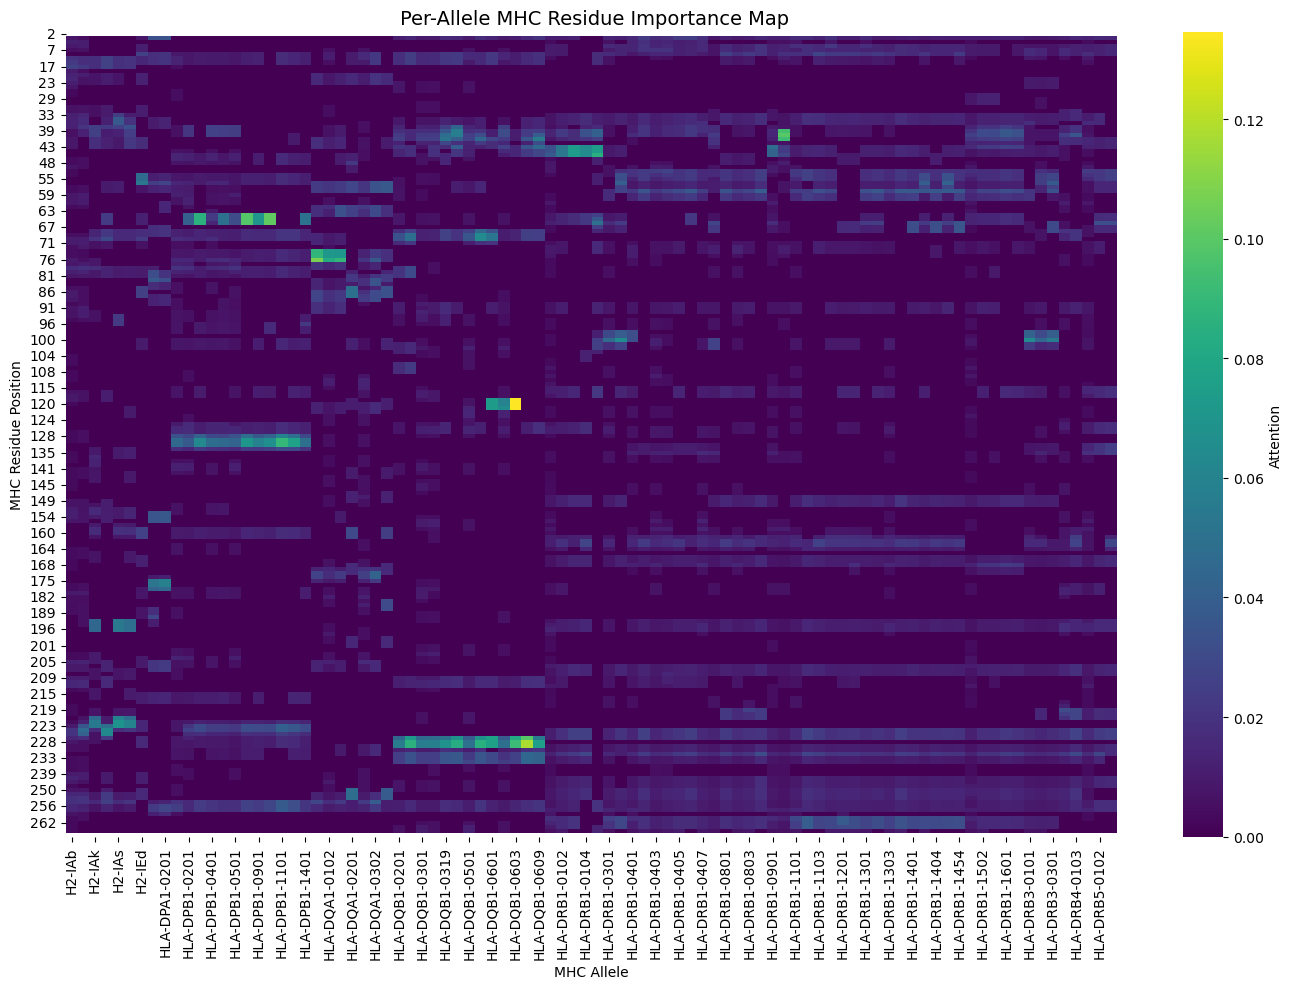

In [60]:
smoothed_df = heatmap_df.rolling(window=3, center=True).mean()

plt.figure(figsize=(14, 10))

sns.heatmap(
    smoothed_df,
    cmap="viridis",
    cbar_kws={"label": "Attention"},
    linewidths=0
)

plt.title(" Per-Allele MHC Residue Importance Map", fontsize=14)
plt.xlabel("MHC Allele")
plt.ylabel("MHC Residue Position")

plt.tight_layout()
plt.savefig(
    "Per_Allele_MHC_Residue_Importance_Map_2_cleaned.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()


##   Peptide position × MHC position interaction matrix

In [98]:
attn_head_avg.shape == (N, 15, 269)


True

In [99]:
# Average across samples
interaction_map = attn_head_avg.mean(axis=0)   # (15, 269)

interaction_df = pd.DataFrame(
    interaction_map,
    index=[f"P{i+1}" for i in range(15)],
    columns=[f"M{i+1}" for i in range(269)]
)


In [100]:
interaction_df.to_csv("peptide_MHC_interaction_preference matrix.csv")

In [101]:
interaction_df

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,...,M260,M261,M262,M263,M264,M265,M266,M267,M268,M269
P1,0.002801,0.006882,0.003151,0.004732,0.001883,0.004956,0.005924,0.002474,0.002670,0.002785,...,0.003075,0.002623,0.009021,0.002498,0.003870,0.002726,0.003995,0.003352,0.002191,0.003341
P2,0.003044,0.006822,0.003263,0.004681,0.002287,0.004767,0.005477,0.002658,0.002903,0.002752,...,0.003004,0.002827,0.008568,0.002607,0.004115,0.003013,0.004323,0.003647,0.002357,0.003268
P3,0.002948,0.006936,0.003224,0.004682,0.002053,0.004998,0.005896,0.002651,0.002833,0.002818,...,0.003196,0.002799,0.008981,0.002571,0.004030,0.002932,0.004215,0.003514,0.002263,0.003409
P4,0.002642,0.007060,0.003192,0.004800,0.002464,0.004414,0.005157,0.002604,0.002909,0.002929,...,0.003392,0.002678,0.009468,0.002468,0.004237,0.003136,0.003981,0.003662,0.002588,0.002820
P5,0.002615,0.006258,0.003087,0.004758,0.002410,0.004194,0.005513,0.002558,0.002830,0.002909,...,0.003324,0.002608,0.008271,0.002502,0.004007,0.002900,0.003886,0.003429,0.002592,0.003027
P6,0.002578,0.008248,0.002878,0.004785,0.001590,0.005061,0.005929,0.002163,0.002498,0.002443,...,0.002895,0.002349,0.010797,0.002160,0.003987,0.002568,0.004352,0.003397,0.001849,0.003119
P7,0.002317,0.007145,0.002776,0.005108,0.001502,0.004558,0.006655,0.002078,0.002419,0.002532,...,0.003047,0.002168,0.010663,0.001988,0.004010,0.002540,0.004129,0.003319,0.001880,0.002974
P8,0.003202,0.006114,0.003262,0.003880,0.002864,0.004814,0.005372,0.003088,0.003007,0.002825,...,0.003217,0.003196,0.007124,0.003431,0.003368,0.002815,0.003840,0.003060,0.002629,0.003358
P9,0.002889,0.005473,0.003500,0.004327,0.003063,0.004090,0.004646,0.003131,0.003382,0.003393,...,0.003593,0.003052,0.006301,0.003022,0.003999,0.003262,0.003868,0.003562,0.003282,0.003235
P10,0.002601,0.007557,0.003066,0.004873,0.001724,0.004900,0.006179,0.002295,0.002485,0.002594,...,0.003074,0.002492,0.012897,0.002256,0.004240,0.002727,0.003986,0.003362,0.001938,0.002900


In [66]:
interaction_df_smoothed = interaction_df.rolling(
    window=3,
    axis=1,
    center=True
).mean()


/tmp/ipykernel_3884519/3446768912.py:1: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  interaction_df_smoothed = interaction_df.rolling(


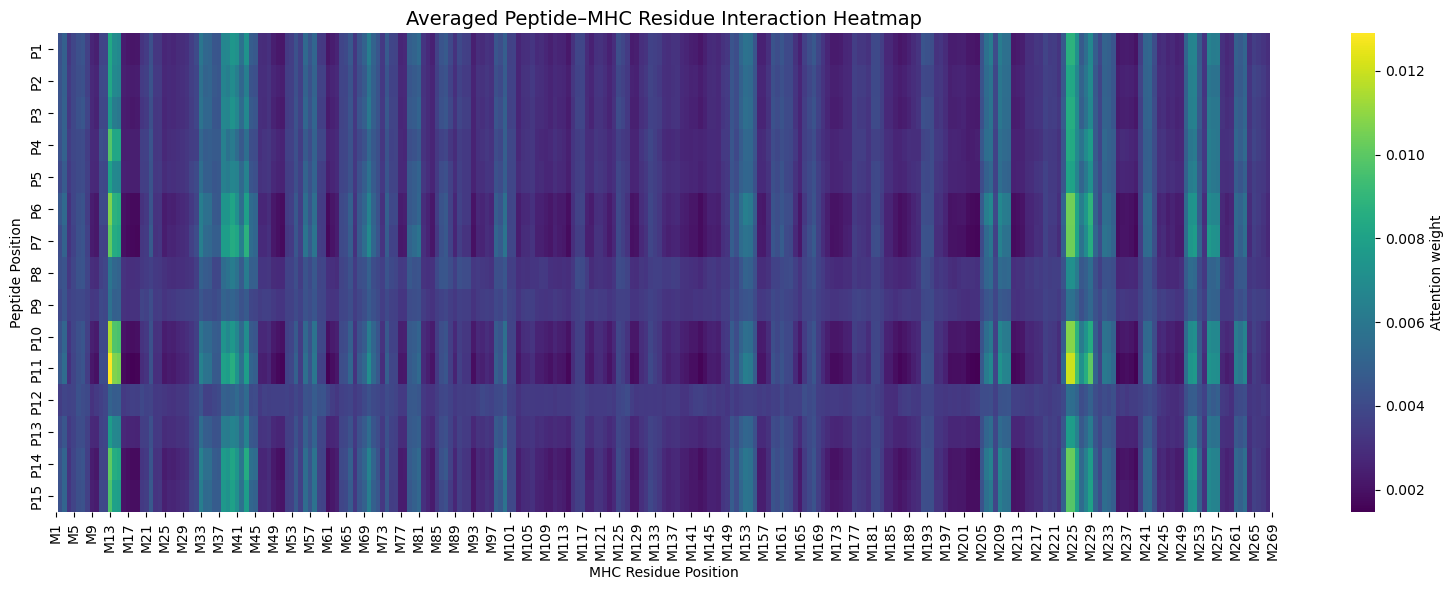

In [69]:
plt.figure(figsize=(16, 6))

sns.heatmap(
    interaction_df_smoothed,
    cmap="viridis",
    cbar_kws={"label": "Attention weight"},
    linewidths=0
)

plt.title(
    "Averaged Peptide–MHC Residue Interaction Heatmap",
    fontsize=14
)
plt.xlabel("MHC Residue Position")
plt.ylabel("Peptide Position")

plt.tight_layout()
plt.savefig(
    " Averaged_Peptide_MHC_Residue_Interaction_Heatmap.pdf",
    format="pdf",
    bbox_inches="tight"
)

plt.show()


#### Allle specific, example HLA-DRB1-0101

In [79]:
allele = "HLA-DRB1-0101"

# get index of the first sample with this allele
sample_idx = df.index[df["MHC_allele"] == allele][0]


In [84]:
peptide_seq = df.loc[sample_idx, "Peptide"]     # length = 15
mhc_seq     = df.loc[sample_idx, "Sequence"]    # length = 269

assert len(peptide_seq) == 15
assert len(mhc_seq) == 269


In [85]:
# attn_head_avg shape: (N, 15, 269)
attn_map = attn_head_avg[sample_idx]   # (15, 269)


In [86]:
allele_df = pd.DataFrame(
    interaction_map,
    index=[f"{aa}{i+1}" for i, aa in enumerate(peptide_seq)],
    columns=[f"{aa}{i+1}" for i, aa in enumerate(mhc_seq)]
)


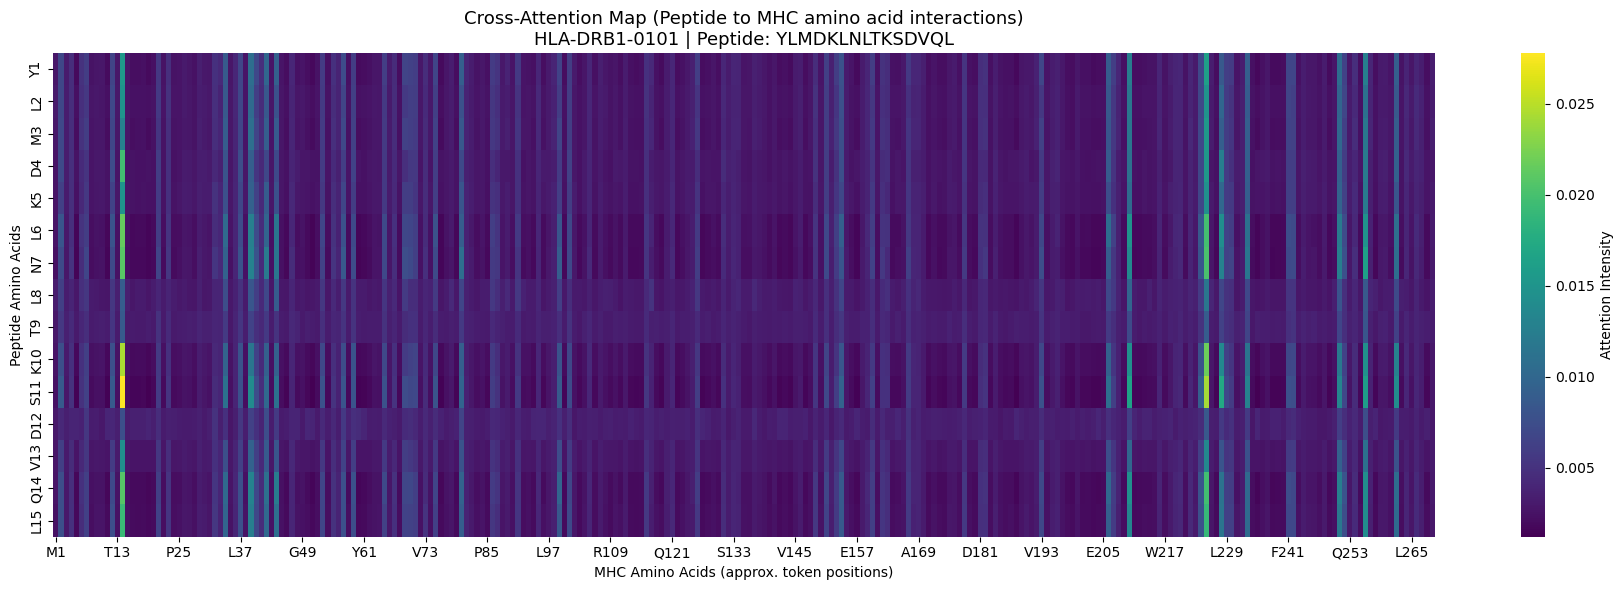

In [89]:
plt.figure(figsize=(18, 6))

sns.heatmap(
    allele_df,
    cmap="viridis",
    cbar_kws={"label": "Attention Intensity"},
    xticklabels=12,        # reduce clutter (show every 12th MHC residue)
    yticklabels=True,
    linewidths=0
)

plt.title(
    "Cross-Attention Map (Peptide to MHC amino acid interactions)\n"
    f"{allele} | Peptide: {peptide_seq}",
    fontsize=13
)

plt.xlabel("MHC Amino Acids (approx. token positions)")
plt.ylabel("Peptide Amino Acids")

plt.tight_layout()
plt.savefig(
    f"Cross_Attention_Map_{allele}.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()


## Mutational sensitivity heatmap

In [30]:
import numpy as np
import pandas as pd

amino_acids = list("ACDEFGHIKLMNPQRSTVWY")


In [31]:
def encode_peptide(peptide):
    return seq_to_int_array(peptide, PEP_LEN)[np.newaxis, :]

def encode_mhc(mhc_seq):
    return seq_to_int_array(mhc_seq, MHC_MAX_LEN)[np.newaxis, :]


In [32]:
def predict_score(model, peptide, mhc_input):
    pep_input = encode_peptide(peptide)

    outputs = model.predict(
        [pep_input, mhc_input],
        verbose=0
    )

    # model returns [y_pred, attn_scores]
    y_pred = outputs[0]

    return float(y_pred[0, 0])


In [132]:
def in_silico_mutagenesis(
    peptide,
    mhc_input,
    model,
    aa_list=AA_LIST
):
    peptide = peptide[:PEP_LEN]
    L = len(peptide)

    base_score = predict_score(model, peptide, mhc_input)

    delta = np.zeros((L, len(aa_list)))

    for i in range(L):
        for j, aa in enumerate(aa_list):
            if peptide[i] == aa:
                delta[i, j] = 0.0
                continue

            mutated = peptide[:i] + aa + peptide[i+1:]
            mut_score = predict_score(model, mutated, mhc_input)

            delta[i, j] = mut_score - base_score

    return delta, base_score


In [140]:
# choose a real sample
sample_idx = 2 # For single allele indexed in 2 

peptide = df.loc[sample_idx, "Peptide"]
mhc_seq = df.loc[sample_idx, "Sequence"]

mhc_input = encode_mhc(mhc_seq)

delta_matrix, base_score = in_silico_mutagenesis(
    peptide=peptide,
    mhc_input=mhc_input,
    model=model
)

print("Base immunogenicity score:", base_score)


Base immunogenicity score: 0.015533427707850933


In [141]:
mut_df = pd.DataFrame(
    delta_matrix,
    columns=AA_LIST,
    index=[f"P{i+1}" for i in range(len(peptide))]
)


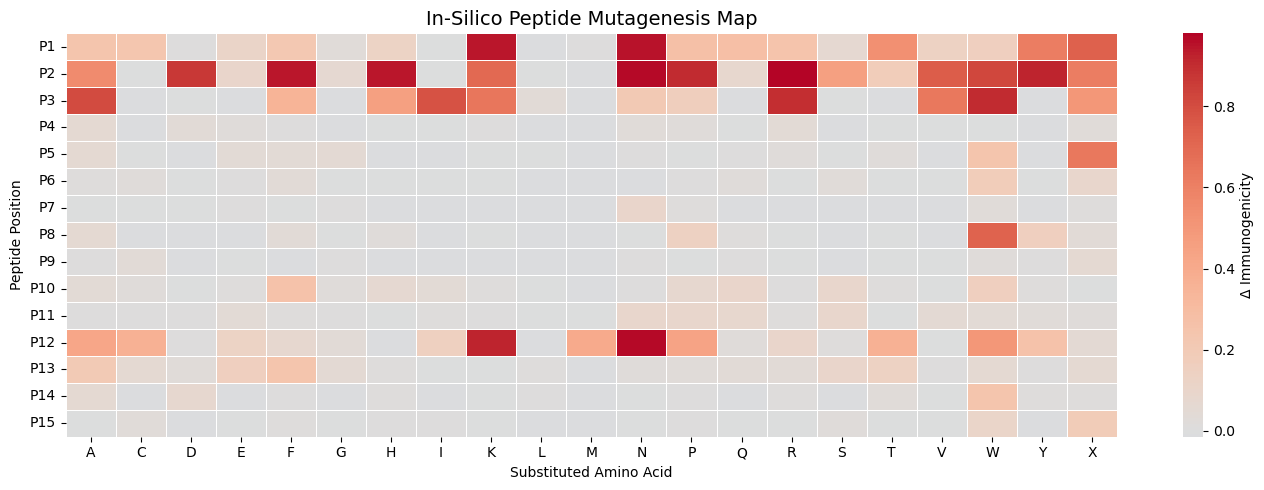

In [142]:
plt.figure(figsize=(14, 5))

sns.heatmap(
    mut_df,
    cmap="coolwarm",
    center=0,
    linewidths=0.4,
    cbar_kws={"label": "Δ Immunogenicity"}
)

plt.title("In-Silico Peptide Mutagenesis Map", fontsize=14)
plt.xlabel("Substituted Amino Acid")
plt.ylabel("Peptide Position")

plt.tight_layout()
#plt.savefig("Peptide_Mutagenesis_Map.pdf", bbox_inches="tight")
plt.show()


###   Aggregated mutational sensitivity map 

In [33]:
def predict_score(model, pep_input, mhc_input):
    pred = model.predict([pep_input, mhc_input], verbose=0)
    if isinstance(pred, list):
        pred = pred[0]          # take first output
    return float(pred.squeeze())


In [34]:
def single_peptide_mutagenesis(peptide, mhc_input, model):
    peptide = peptide[:PEP_LEN]
    L = len(peptide)

    base_pep = encode_peptide(peptide)
    base_score = predict_score(model, base_pep, mhc_input)

    delta = np.zeros((L, len(AA_LIST)))

    for i in range(L):
        for j, aa in enumerate(AA_LIST):
            if peptide[i] == aa:
                delta[i, j] = 0.0
                continue

            mutated = list(peptide)
            mutated[i] = aa
            mutated = "".join(mutated)

            pep_input = encode_peptide(mutated)
            mut_score = predict_score(model, pep_input, mhc_input)

            delta[i, j] = mut_score - base_score

    return delta


In [43]:
#df_sub = df[df["Immunogenicity"] == 1].reset_index(drop=True)
df_sub = (
    df[df["Immunogenicity"] == 1]
    .iloc[:20]
    .reset_index(drop=True)
)


In [44]:
all_maps = []

for idx in range(len(df_sub)):
    peptide = df_sub.loc[idx, "Peptide"]
    mhc_seq = df_sub.loc[idx, "Sequence"]

    mhc_input = encode_mhc(mhc_seq)

    delta_map = single_peptide_mutagenesis(
        peptide=peptide,
        mhc_input=mhc_input,
        model=model
    )

    all_maps.append(delta_map)

all_maps = np.stack(all_maps)  # (N_peptides, 15, 21)


In [ ]:
np.save("mutagenesis.npy", np.array(all_maps, dtype=np.float32))


In [45]:
agg_map = all_maps.mean(axis=0)   # shape: (15, 21)


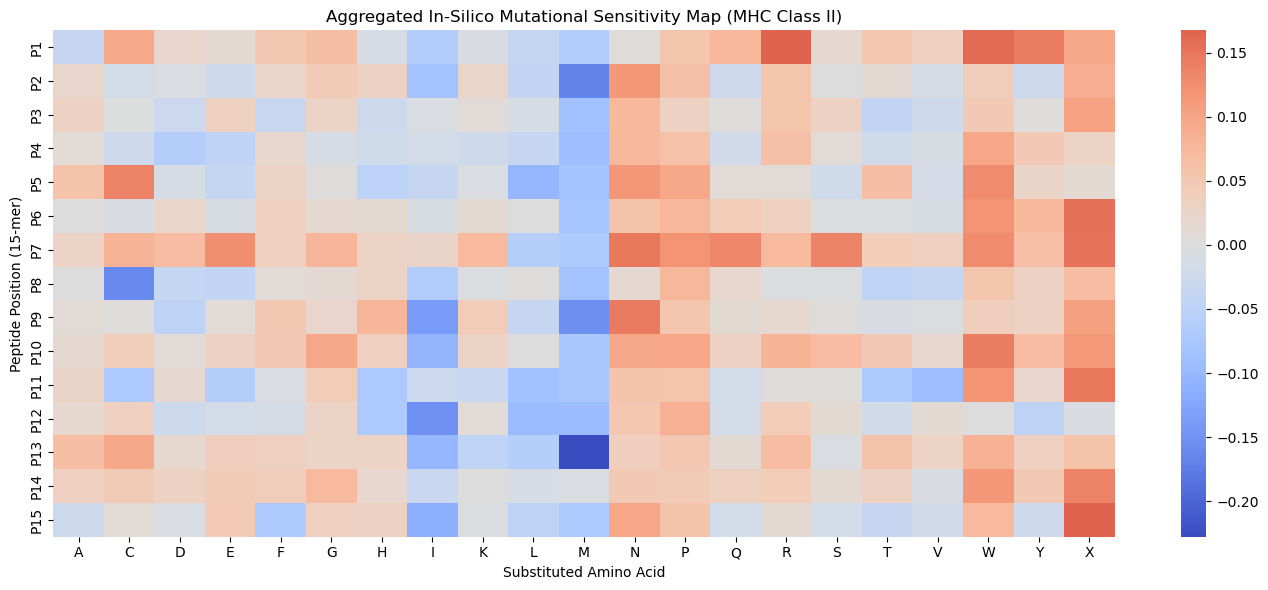

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(
    agg_map,
    cmap="coolwarm",
    center=0,
    xticklabels=AA_LIST,
    yticklabels=[f"P{i+1}" for i in range(PEP_LEN)]
)

plt.xlabel("Substituted Amino Acid")
plt.ylabel("Peptide Position (15-mer)")
plt.title("Aggregated In-Silico Mutational Sensitivity Map (MHC Class II)")
plt.tight_layout()
plt.show()


In [21]:
#Peptide position sensitivity

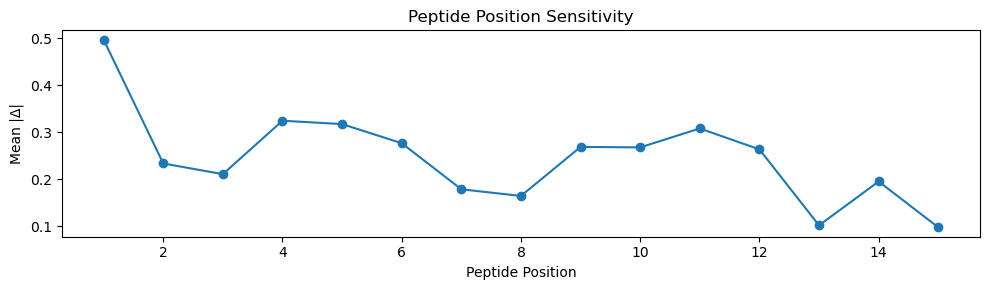

In [136]:
position_sensitivity = np.mean(np.abs(delta_matrix), axis=1)

plt.figure(figsize=(10, 3))
plt.plot(range(1, len(peptide)+1), position_sensitivity, marker="o")

plt.xlabel("Peptide Position")
plt.ylabel("Mean |Δ|")
plt.title("Peptide Position Sensitivity")

plt.tight_layout()
plt.savefig("Peptide_Position_Sensitivity.pdf")
plt.show()


## Cross-Attention Entropy / Focus Analysis

In [106]:
attn_scores.shape 


(7887, 4, 15, 269)

In [107]:
attn_head_avg = attn_scores.mean(axis=1)

In [108]:
eps = 1e-9  # numerical stability

# Normalize across MHC positions
attn_prob = attn_head_avg / (attn_head_avg.sum(axis=-1, keepdims=True) + eps)


In [110]:
entropy = -np.sum(attn_prob * np.log(attn_prob + eps), axis=-1)


In [111]:
mean_entropy = entropy.mean(axis=0)    # (15,)
std_entropy  = entropy.std(axis=0)


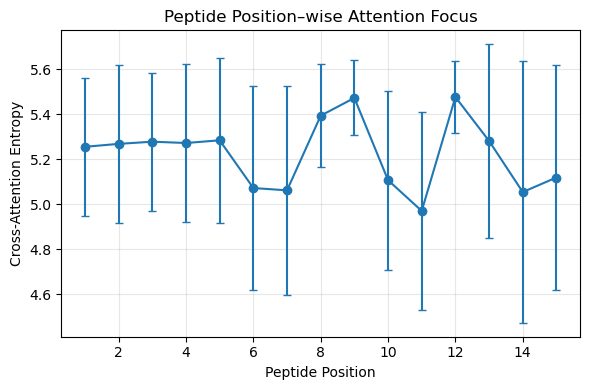

In [112]:
plt.figure(figsize=(6,4))
plt.errorbar(
    x=np.arange(1, 16),
    y=mean_entropy,
    yerr=std_entropy,
    marker="o",
    capsize=3
)

plt.xlabel("Peptide Position")
plt.ylabel("Cross-Attention Entropy")
plt.title("Peptide Position–wise Attention Focus")
plt.grid(alpha=0.3)
plt.tight_layout()
#plt.savefig("Peptide_Attention_Entropy.pdf", format="pdf")
plt.show()


### Alllele clustering
Clustering is based on similarity of residue importance profiles, Metric: correlation

/BiO/home/jk/anaconda3/envs/jk_gpu2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/BiO/home/jk/anaconda3/envs/jk_gpu2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


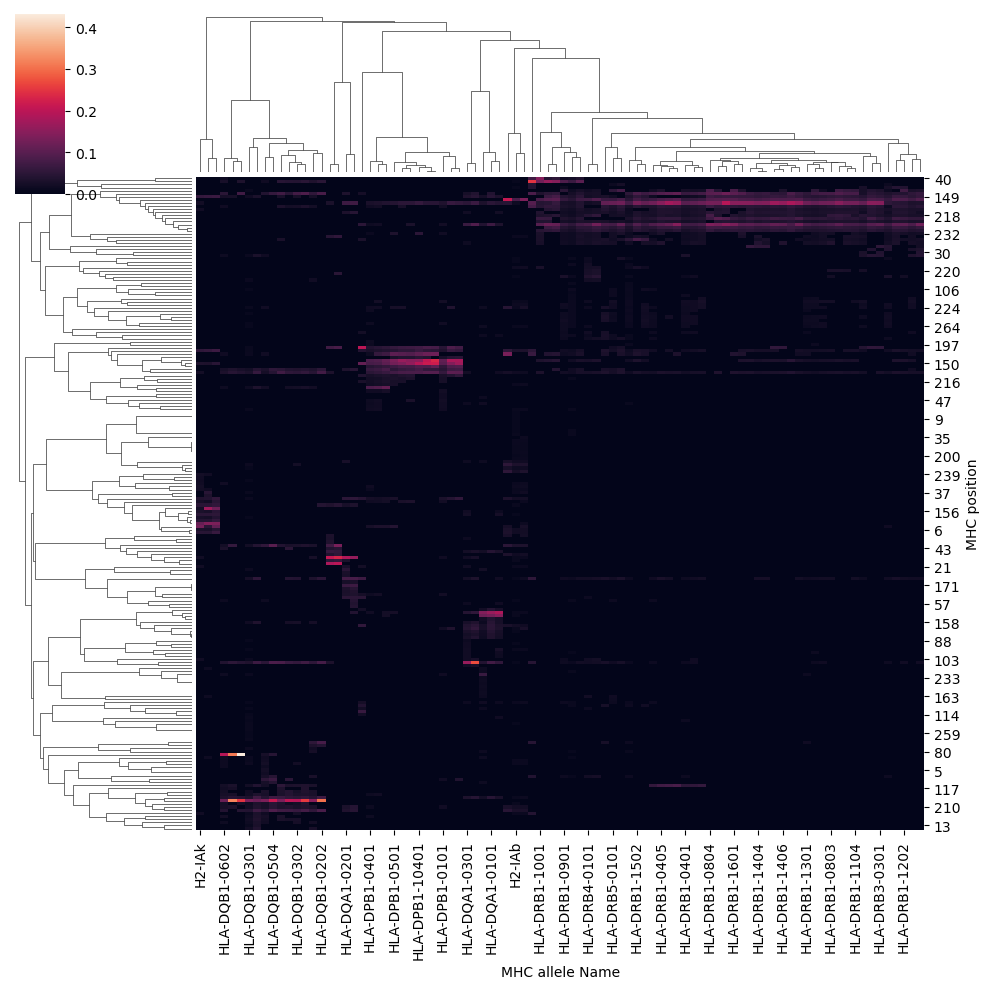

In [117]:
g=sns.clustermap(heatmap_df, metric="correlation")
g.savefig("allele_residue_clustermap.pdf", format="pdf")

#### Integrated Grading for motifs discovery

In [ ]:
pep_embedding_layer = model.get_layer("embedding_2")

# Model that outputs peptide embeddings
pep_embedding_model = tf.keras.Model(
    inputs=model.inputs,
    outputs=pep_embedding_layer.output
)


In [ ]:
def integrated_gradients_embedding(
    model,
    embedding_tensor,
    full_inputs,
    steps=50
):
    """
    IG w.r.t peptide embedding (embedding_2)
    embedding_tensor: (1, 15, 16)
    full_inputs: [pep_tok, mhc_tok, esm_pep, esm_mhc]
    """

    baseline = tf.zeros_like(embedding_tensor)
    alphas = tf.linspace(0.0, 1.0, steps)

    grads_accum = tf.zeros_like(embedding_tensor)

    for alpha in alphas:
        interp = baseline + alpha * (embedding_tensor - baseline)

        with tf.GradientTape() as tape:
            tape.watch(interp)

            # forward pass using interpolated embedding
            pred = model([
                full_inputs[0],  # pep_tok
                full_inputs[1],  # mhc_tok
                #full_inputs[2],  # esm_pep (unchanged)
                #full_inputs[3],  # esm_mhc
            ])

        grads = tape.gradient(pred, interp)

        if grads is not None:
            grads_accum += grads

    avg_grads = grads_accum / steps
    ig = (embedding_tensor - baseline) * avg_grads

    return ig


In [ ]:
allele_ig_results = {}

for allele in alleles:
    print(f"\nProcessing allele: {allele}")

    idx = np.where(df["MHC_allele"].values == allele)[0]

    pep_seqs = df.iloc[idx]["Peptide"].tolist()
    ig_all = []

    for i in idx:
        inputs = [
            xp_all,
            xm_all,
            #X_esm_pep_val[i:i+1],
            #X_esm_mhc_val[i:i+1],
        ]

        # get peptide embedding
        pep_emb = pep_embedding_model(inputs, training=False)

        # IG
        ig = integrated_gradients_embedding(
            model,
            pep_emb,
            inputs,
            steps=50
        )

        # collapse embedding dimension → per-position score
        ig_pos = tf.reduce_sum(tf.abs(ig), axis=-1).numpy().squeeze()
        ig_all.append(ig_pos)

    allele_ig_results[allele] = np.vstack(ig_all)

    print(f"  peptides: {len(ig_all)}")


In [ ]:
def build_motif(peptides, ig_scores):
    L = ig_scores.shape[1]
    aa_scores = {pos: {} for pos in range(L)}

    for pep, score in zip(peptides, ig_scores):
        for pos, aa in enumerate(pep):
            aa_scores[pos][aa] = aa_scores[pos].get(aa, 0) + score[pos]

    motif = pd.DataFrame(aa_scores).fillna(0)
    motif = motif / motif.sum(axis=0)
    return motif

In [ ]:
allele = alleles[0]  # select an allle example
idx = np.where(data_val["MHC_allele"].values == allele)[0]
peptides = data_val.iloc[idx]["Peptide"].tolist()

motif_df = build_motif(peptides, allele_ig_results[allele])
motif_df